# Import Properties

In [48]:
import pandas as pd
import torch
import re
import emoji
import string
import numpy as np
import torch
import time
import optuna
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import xgboost as xgb
import json
import joblib
import seaborn as sns
from xgboost import XGBClassifier
from xgboost.callback import TrainingCallback
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler, BertModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from tqdm.auto import tqdm

In [49]:
# Check if there any GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'There are {torch.cuda.device_count()} GPU available') # avaiable count GPU
    print (f'Using "{torch.cuda.get_device_name(0)}" as the GPU', ) # name using GPU  
else:
    print ('No gpu avaiable')
    device = torch.device('cpu')

There are 1 GPU available
Using "NVIDIA GeForce RTX 3060 Ti" as the GPU


# Pre-processing

In [50]:
# Show top of dataset
df = pd.read_csv('./multilabel-dataset/re_dataset.csv', encoding='latin1')
df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [51]:
# Remove columns yang tidak diperlukan
df.drop(columns = ['Abusive',
                   'HS_Individual',
                   'HS_Group', 
                   'HS_Religion', 
                   'HS_Race', 
                   'HS_Physical', 
                   'HS_Gender', 
                   'HS_Other', 
                   'HS_Weak', 
                   'HS_Moderate', 
                   'HS_Strong'], inplace=True)

In [52]:
# Check is null value
df.isnull().sum()

Tweet    0
HS       0
dtype: int64

In [53]:
# Remove duplicates
df = df.drop_duplicates(subset=['Tweet'])

In [54]:
# Check jumlah row and column
df.shape

(13023, 2)

In [55]:
# Check again after remove columns
df.head()

,Tweet,HS
0,- disaat semua cowok berusaha melacak perhatia...,1
1,RT USER: USER siapa yang telat ngasih tau elu?...,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1


## Steps to clean dataset

1. Import slang dataset and convert slang dataset to dictionary
2. Convert to lower case  
3. Remove url 
4. Remove hastag
5. Normalize Unicode like "\x9f\x80\xA0"
6. Remove symbolsdan tanda baca
7. Remove repetitive character
8. Remove repetitive words
9. Remove whitespace (spasi)
10. Normalize slang/alay words using dictionary
11. Remove word user
12. Remove retweet 
13. Remove non-ascii character
14. Remove emojis and emojis classic

In [56]:
# Load slang words
df_kamusalay = pd.read_csv('./multilabel-dataset/new_kamusalay.csv', names=["slang", "formal"], encoding='latin1')
df_kamusalay.head()

,slang,formal
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [57]:
# Convert csv data ke dictionary (lebih mudah digunakan)
alay_dict = dict(zip(df_kamusalay["slang"], df_kamusalay["formal"]))

In [58]:
# Show data dictionary
alay_dict

{'anakjakartaasikasik': 'anak jakarta asyik asyik',
 'pakcikdahtua': 'pak cik sudah tua',
 'pakcikmudalagi': 'pak cik muda lagi',
 't3tapjokowi': 'tetap jokowi',
 '3x': 'tiga kali',
 'aamiin': 'amin',
 'aamiinn': 'amin',
 'aamin': 'amin',
 'aammiin': 'amin',
 'abis': 'habis',
 'abisin': 'habiskan',
 'acau': 'kacau',
 'achok': 'ahok',
 'ad': 'ada',
 'adek': 'adik',
 'adl': 'adalah',
 'adlah': 'adalah',
 'adlh': 'adalah',
 'ado': 'ada',
 'aduhh': 'aduh',
 'aer': 'air',
 'afdol': 'afdal',
 'agamaataualqur': 'agama alquran',
 'agm': 'agama',
 'agma': 'agama',
 'ahaha': 'haha',
 'ahahaha': 'haha',
 'ahehehehe': 'hehe',
 'ahir': 'akhir',
 'ahirnya': 'akhirnya',
 'ahk': 'ahok',
 'ahlamdulillah': 'alhamdulillah',
 'ahli2': 'para ahli',
 'ahlusunnah': 'ahlus sunah',
 'ahmaddani': 'ahmad dhani',
 'aho': 'ahok',
 'ahoax': 'ahok',
 'ahoaxx': 'ahok',
 'ahog': 'ahok',
 'ahokataudjarot': 'ahok djarot',
 'ahokbebanijokowi': 'ahok beban jokowi',
 'ahokbtp': 'ahok basuki tjahaja purnama',
 'ahokditolakw

In [59]:
# Count total of slang dictionary
print(f"Jumlah slang yang ditemukan: {len(alay_dict)}")

Jumlah slang yang ditemukan: 15167


### Cleaning Tweet Text
 

In [60]:
# to lower 
def to_lower(text):
    return text.lower()

# remove URLs
def remove_URL(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    return text

# remove mention and hashtag
def remove_hastag(text):
    text = re.sub(r'@\w+', '', text)
    #text = re.sub(r'#\w+', '', text)
    return text.strip()

# remove words like "\x9f\x80\xA0"
def normalize_unicode(text):
    return re.sub(r'(\\x[\da-fA-F]{2})+', '', text)

# remove symbols
def remove_punctuation(text):
    #text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)    # Hilangkan tanda baca standar
    text = re.sub(r"[^\w\s]", " ", text)    # Hilangkan simbol non-alfanumerik selain spasi 
    text = re.sub(r"\s+", " ", text).strip()     # Hapus spasi berlebih
    text = re.sub(r'[\'\"\“”‘’;:\n\r]', ' ', text) 
    return text

# remove whitespace (spasi)
def remove_whitespace(text):            
    # Perbaiki escape sequence literal
    text = re.sub(r"/t", "\t", text)  # Ganti "/t" dengan tab asli
               
    # Gabungkan whitespace yang berlebihan secara selektif
    text = re.sub(r" +", " ", text)     # Hapus spasi berlebih
    text = re.sub(r"\n+", "\n", text)    # Hapus newline berlebih
    text = re.sub(r"\r+", "\r", text)    # Hapus carriage return berlebih
    text = re.sub(r"\t+", "\t", text)    # Hapus tab berlebih
    return text.strip(" ")

# normalize alay words using dictionary
def normalize_alay(text, alay_dict=alay_dict):
    return ' '.join([alay_dict.get(word, word) for word in text.split()])

# remove user Words               
def remove_user_words(text):
    return re.sub(r'\bUSER\b', '', text)

# remove retweet             
def remove_retweet(text):
    return re.sub(r'^\s*RT\s*[:\-\—]?\s*', '', text)

# remove non-ascii
def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

In [61]:
# Preprocess function
def preprocess_text(text, alay_dict):
    text = to_lower(text)
    text = remove_URL(text)
    text = remove_retweet(text)
    text = remove_hastag(text)
    text = normalize_unicode(text)
    text = remove_non_ascii(text)
    text = remove_whitespace(text)
    text = remove_punctuation(text)
    text = remove_user_words(text)
    text = normalize_alay(text, alay_dict)
    return text

In [62]:
# Cleaning Tweet dan save in clean_text column
df['clean_text'] = df['Tweet'].apply(lambda x: preprocess_text(x, alay_dict))

In [63]:
# Save to csv 
df.to_csv("cleaned_dataset.csv", index=False)
print("Cleaning selesai! Dataset disimpan sebagai cleaned_dataset.csv")

Cleaning selesai! Dataset disimpan sebagai cleaned_dataset.csv


## Test Clean Function 

In [64]:
# Test tweet (1)
tweet = "USER USER USER USER Wuih... cebong sewot...\n\xf0\x9f\x98\x82\xf0\x9f\x98\x82\xf0\x9f\x98\x82"
cleaned_tweet = preprocess_text(tweet, alay_dict)
print(cleaned_tweet)

pengguna pengguna pengguna pengguna wah cebong sewot


In [65]:
# Test tweet (2)
tweet2 = "Syg bgt ya ngeliat perempuan kyk gini... Gak ada status apa2 tp udah nemplok sm laki-laki sana sini. Haduh....\nNagita Slavina Blak-blakan Sebut Ayu Ting Ting Kampungan \xe2\x80\x93 VIVA URL"
cleaned = preprocess_text(tweet2, alay_dict)
print(cleaned)

sayang banget ya melihat perempuan kayak begini tidak ada status apa apa tetapi sudah menempel sama laki laki sana sini aduh nagita slavina blak blak sebut ayu ting ting kampungan viva uniform resource locator


## Add Kata Kasar Dictionary

In [66]:
# Open clean dataset & show
df_2 = pd.read_csv('cleaned_dataset.csv')
df_2 = df_2.drop(columns=['Tweet'])
df_2.tail()

,HS,clean_text
13018,1,pengguna jangan asal berbicara ndasmu congor k...
13019,0,pengguna kasur mana enak kunyuk
13020,0,pengguna hati hati bisu tidak dan lagi bosan duh
13021,0,pengguna pengguna pengguna pengguna bom yang r...
13022,1,pengguna mana situ memberi itu cuma foto ya ku...


In [67]:
# Check is null value
df_2 = df_2.dropna(subset=['clean_text'])
df_2.isnull().sum()

HS            0
clean_text    0
dtype: int64

In [68]:
# Check distribution label
print(df_2['HS'].value_counts())

0    7522
1    5501
Name: HS, dtype: int64


In [69]:
# Tambahkan Abusive -> Hate-Speech

# Load kamus kata kasar dari eksternal dictionary
with open('./kata_kasar.txt', 'r', encoding='utf-8') as f:
    daftar_kasar = [baris.strip().lower() for baris in f if baris.strip()]

# Cek distribusi label 0 yang mengandung kata kasar
def mengandung_kata_kasar(teks, daftar_kasar):
    return any(kata in teks.lower().split() for kata in daftar_kasar)

# Filter data
potensi_mislabel = df_2[(df_2['HS'] == 0) & (df_2['clean_text'].apply(lambda x: mengandung_kata_kasar(str(x), daftar_kasar)))]

# Simpan untuk audit manual
potensi_mislabel.to_csv('potensi_mislabeling.csv', index=False)
print(f"Jumlah potensi mislabeling ditemukan: {len(potensi_mislabel)}")

Jumlah potensi mislabeling ditemukan: 1030


In [70]:
# Sample untuk audit data potensial mislabel
sample = potensi_mislabel.sample(50, random_state=42)
sample.to_csv('audit_sample.csv', index=False)

In [71]:
# Update label HS 0 menjadi 1 untuk data yang mengandung kata kasar
df_2.loc[potensi_mislabel.index, 'HS'] = 1

# Simpan DataFrame yang sudah diperbarui jika perlu
df_2.to_csv('df_2_terupdate.csv', index=False)
print("Label telah diperbarui untuk data yang mengandung kata kasar.")

Label telah diperbarui untuk data yang mengandung kata kasar.


In [72]:
# Check distribution label
print(df_2['HS'].value_counts())

1    6531
0    6492
Name: HS, dtype: int64


## Split Dataset

In [73]:
# Stratified split (tetap menjaga distribusi label dengan seimbang)

# Split 70% train dan 30% temp validation
train_idx, temp_idx = train_test_split(
    list(range(len(df_2))), test_size=0.3, random_state=42, stratify=df_2['HS']
)

# Ambil label dari temp untuk stratified split kedua
temp_labels = [df_2['HS'].iloc[i] for i in temp_idx]

# Split temp menjadi validation dan test (masing-masing 15%)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, random_state=42, stratify=temp_labels
) # 30% . 0.5 = 15%

In [74]:
# Hitung jumlah data
print("Jumlah data:")
print("Train     :", len(train_idx))
print("Validation:", len(val_idx))
print("Test      :", len(test_idx))

Jumlah data:
Train     : 9116
Validation: 1953
Test      : 1954


In [75]:
# Ambil label untuk masing-masing indeks
train_labels = df_2.iloc[train_idx]['HS']
val_labels = df_2.iloc[val_idx]['HS']
test_labels = df_2.iloc[test_idx]['HS']

# Hitung distribusi label
print("Distribusi label (Train):")
print(train_labels.value_counts(normalize=True))

print("\nDistribusi label (Validation):")
print(val_labels.value_counts(normalize=True))

print("\nDistribusi label (Test):")
print(test_labels.value_counts(normalize=True))

Distribusi label (Train):
1    0.501536
0    0.498464
Name: HS, dtype: float64

Distribusi label (Validation):
1    0.50128
0    0.49872
Name: HS, dtype: float64

Distribusi label (Test):
1    0.501535
0    0.498465
Name: HS, dtype: float64


In [76]:
# Ambil subset dari df_2
train_df = df_2.iloc[train_idx]
val_df = df_2.iloc[val_idx]
test_df = df_2.iloc[test_idx]

# Show 5 acak dari setiap subset
print("=== Train Sample ===")
print(train_df[['clean_text', 'HS']].sample(5))

print("\n=== Validation Sample ===")
print(val_df[['clean_text', 'HS']].sample(5))

print("\n=== Test Sample ===")
print(test_df[['clean_text', 'HS']].sample(5))

=== Train Sample ===
                                              clean_text  HS
11982                   pengguna kunyuk asia antek asing   1
11048  tau kenapa kalau anda bicara tumpas partai kom...   1
2543   pengguna lebih baik pilih ahok daripada pilih ...   1
6716   pengguna awalnya pasti pikir tidak kok tidak c...   0
9331   rt pengguna monyet belum dan ahok tidak bisa t...   1

=== Validation Sample ===
                                              clean_text  HS
12765  rt pengguna pengguna para partai oposisi zaman...   1
5465   jokowi dulu merangkap menteri punya sekarang m...   0
19                                 pengguna alga mnr bom   0
5310   pengguna pesimis culun dasar doa saja dulu sap...   1
5700   horas horas horas dengan menggunakan kapal fer...   0

=== Test Sample ===
                                              clean_text  HS
12969  rt pengguna pengguna dirtbag dan show kalau me...   0
519    video call dengan pak gubernur pengguna yang s...   0
6532   pengguna 

In [77]:
# Count distribusi label train / val / test
print("Train:", Counter(train_df['HS']))
print("Validation:", Counter(val_df['HS']))
print("Test:", Counter(test_df['HS']))

Train: Counter({1: 4572, 0: 4544})
Validation: Counter({1: 979, 0: 974})
Test: Counter({1: 980, 0: 974})


In [78]:
# check avg panjang text train / val / test
train_df['length'] = train_df['clean_text'].apply(lambda x: len(x.split()))
val_df['length'] = val_df['clean_text'].apply(lambda x: len(x.split()))
test_df['length'] = test_df['clean_text'].apply(lambda x: len(x.split()))

print("Train avg len:", train_df['length'].mean())
print("Val avg len:", val_df['length'].mean())
print("Test avg len:", test_df['length'].mean())

Train avg len: 18.828652917946467
Val avg len: 18.674859190988222
Test avg len: 19.017911975435005


C:\Users\monet\AppData\Local\Temp\ipykernel_13724\3348247515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['length'] = train_df['clean_text'].apply(lambda x: len(x.split()))
C:\Users\monet\AppData\Local\Temp\ipykernel_13724\3348247515.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['length'] = val_df['clean_text'].apply(lambda x: len(x.split()))
C:\Users\monet\AppData\Local\Temp\ipykernel_13724\3348247515.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

# BERT Tokenezation & Embeddings

In [79]:
# Load IndoBERT (large model: 1024 dim)
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
bert_model = BertModel.from_pretrained('indobenchmark/indobert-base-p1')
bert_model.eval()
bert_model.to(device)
hidden_size = bert_model.config.hidden_size 

# Fungsi untuk ekstrak embedding dengan mean pooling
def get_bert_embedding(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding='max_length',
        max_length=128
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = bert_model(**inputs)

    # Ambil seluruh token embeddings dan attention mask
    last_hidden_state = outputs.last_hidden_state.squeeze(0)      # shape: (seq_len, hidden_size)
    attention_mask = inputs['attention_mask'].squeeze(0)          # shape: (seq_len)

    # Masked mean pooling (hanya token yang bukan padding)
    masked_embeddings = last_hidden_state * attention_mask.unsqueeze(-1)  # (seq_len, hidden_size)
    sum_embeddings = masked_embeddings.sum(dim=0)
    count_tokens = attention_mask.sum()
    mean_embedding = sum_embeddings / count_tokens

    return mean_embedding.cpu().numpy()

# Generate embeddings dari DataFrame
def generate_embeddings(dataframe):
    embeddings = []
    for text in tqdm(dataframe['clean_text'], desc="Generating embeddings"):
        try:
            emb = get_bert_embedding(text)
        except Exception as e:
            print(f"Error: {e}")
            emb = np.zeros(hidden_size)  # fallback sesuai model
        embeddings.append(emb)
    return np.vstack(embeddings)


# Hasilkan embedding untuk train, val, test
X_train = generate_embeddings(train_df)
X_val = generate_embeddings(val_df)
X_test = generate_embeddings(test_df)

# Label target
y_train = train_df['HS'].astype(int).values
y_val = val_df['HS'].astype(int).values
y_test = test_df['HS'].astype(int).values

Generating embeddings:   0%|          | 0/9116 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/1953 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/1954 [00:00<?, ?it/s]

In [80]:
# Lihat vektor embedding untuk teks pertama
print("Contoh embedding:", X_train[0])
print("Panjang vektor:", len(X_train[0]))

Contoh embedding: [ 5.03690302e-01  1.08906460e+00  7.76070774e-01  7.87719265e-02
  1.06306171e+00  7.71222949e-01 -1.15027046e+00  3.65364373e-01
  1.48929811e+00 -4.79609400e-01 -4.71846491e-01  4.96562608e-02
 -1.17244315e+00  6.92779422e-01  1.17687441e-01 -1.20010912e-01
  1.97280005e-01 -7.68428206e-01  1.19469307e-01  3.76177609e-01
  1.38637948e+00  6.41435683e-01 -1.06066778e-01  9.72037688e-02
 -6.34211361e-01  3.77760231e-01  4.10417557e-01  6.65672064e-01
  9.28306758e-01 -2.36791462e-01  2.48080581e-01  1.29470980e+00
  5.50877690e-01  1.05350351e+00 -1.72727466e+00  5.39875984e-01
 -6.03838086e-01 -1.68854997e-01 -2.71096051e-01  2.01491127e-03
 -4.94517744e-01 -1.80723637e-01 -1.51873916e-01  3.59161139e-01
 -6.87285900e-01  5.22990227e-01  4.22664970e-01  9.47267890e-01
 -3.28642428e-02  1.46675035e-01 -4.55417097e-01 -5.60241699e-01
  3.47841799e-01  1.05494571e+00  2.76660383e-01 -9.49215889e-03
  5.39583862e-01 -4.63473022e-01  1.09590866e-01  2.57097781e-01
  5.119

# XGBoost

In [81]:
# # Inisialisasi dan latih model
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# xgb_model.fit(X_train, y_train)

# # Evaluasi
# val_preds = xgb_model.predict(X_val)
# print("Validation Report:")
# print(classification_report(y_val, val_preds))

# test_preds = xgb_model.predict(X_test)
# print("Test Report:")
# print(classification_report(y_test, test_preds))

In [82]:
# # Evaluasi di validation set
# val_preds = xgb_model.predict(X_val)
# print("Validation Report:")
# print(classification_report(y_val, val_preds))

# # Evaluasi di test set
# test_preds = xgb_model.predict(X_test)
# print("Test Report:")
# print(classification_report(y_test, test_preds))

# # Confusion matrix untuk test set
# cm = confusion_matrix(y_test, test_preds)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()

### Tuning Hyperparameter

##### Grid Seach

In [83]:
# # Hitung perbandingan kelas untuk imbalanced data
# weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# # Grid parameter
# param_grid = {
#     'max_depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', scale_pos_weight=weight)

# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
#                            scoring='f1', cv=3, verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# # Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}

##### Optuna

In [84]:
# # Hitung rasio kelas (untuk data imbalance)
# weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# # Fungsi objective untuk Optuna
# def objective(trial):
#     # Coba kombinasi hyperparameter
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 4, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 300),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'scale_pos_weight': weight,
#         'use_label_encoder': False,
#         'eval_metric': 'mlogloss',
#         'random_state': 42,
#         'n_jobs': -1
#     }

#     model = XGBClassifier(**params)

#     # 3-fold Stratified CV
#     cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#     scores = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

#     return scores.mean()

# # Buat study Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50, timeout=600)  # Bisa diatur sesuai kebutuhan

# # Cetak hasil terbaik
# print("Best trial:")
# print(f"  Value (F1): {study.best_trial.value}")
# print(f"  Params: {study.best_trial.params}")

In [85]:
# optuna.visualization.plot_optimization_history(study)
# optuna.visualization.plot_param_importances(study)

In [86]:
# best_params = study.best_trial.params
# model = XGBClassifier(**best_params, scale_pos_weight=weight, use_label_encoder=False, eval_metric='mlogloss')
# model.fit(X_train, y_train)

# XGBoost Tuned Model

In [87]:
# Buat DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameter model
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 5,
    'gamma' : 0.5,
    'reg_alpha': 0.7,
    'reg_lambda': 2.0,
    'eval_metric': 'logloss'
}

# Hasil evaluasi logloss dan metrik tambahan
evals_result = {}
history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}

# Callback custom untuk logging metrik
class CustomMetricLogger(TrainingCallback):
    def __init__(self, dval, y_val, evals_result, history):
        self.dval = dval
        self.y_val = y_val
        self.evals_result = evals_result
        self.history = history

    def after_iteration(self, model, epoch, evals_log):
        y_pred_proba = model.predict(self.dval, iteration_range=(0, epoch + 1))
        y_pred = (y_pred_proba > 0.5).astype(int)

        acc = accuracy_score(self.y_val, y_pred)
        prec = precision_score(self.y_val, y_pred, zero_division=0)
        rec = recall_score(self.y_val, y_pred, zero_division=0)
        f1 = f1_score(self.y_val, y_pred, zero_division=0)

        self.history['train_loss'].append(evals_log['train']['logloss'][epoch])
        self.history['val_loss'].append(evals_log['val']['logloss'][epoch])
        self.history['val_acc'].append(acc)
        self.history['val_precision'].append(prec)
        self.history['val_recall'].append(rec)
        self.history['val_f1'].append(f1)

        return False

# Training
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=10,
    evals_result=evals_result,
    callbacks=[CustomMetricLogger(dval, y_val, evals_result, history)],
    verbose_eval=False
)


# Evaluation Report & Confusion Matrix

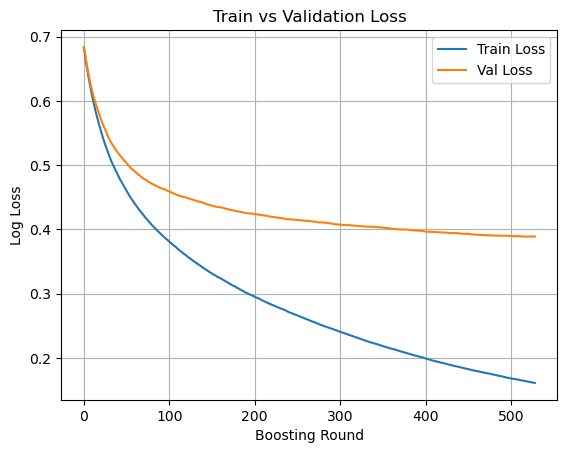

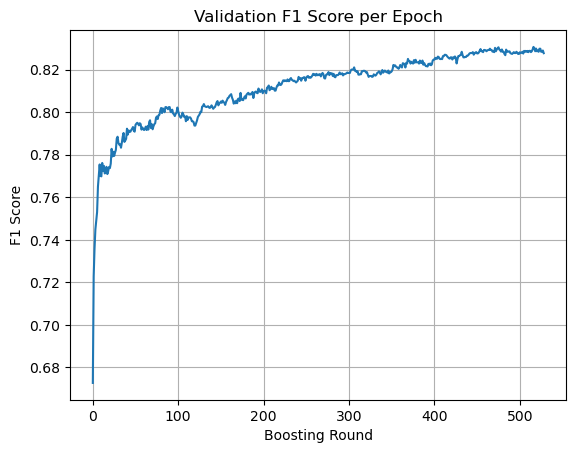

In [88]:
# Plot loss
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1
plt.plot(history['val_f1'], label='Val F1 Score')
plt.xlabel('Boosting Round')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score per Epoch')
plt.grid(True)
plt.show()

In [89]:
# walaupun terdapat gap antara train dan validation, model masih dapat mengidentifikasi terhadap generalization data. 

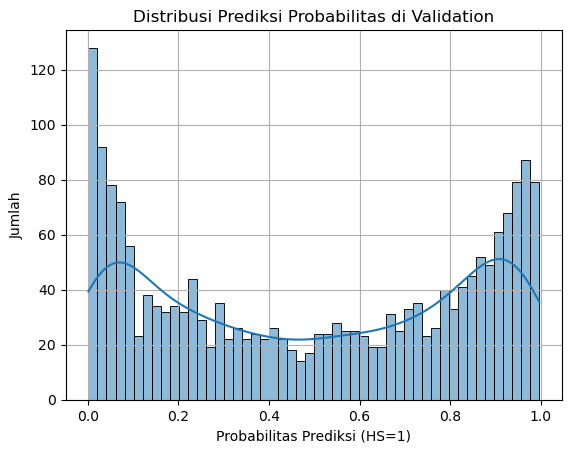

In [90]:
y_val_proba = model.predict(dval)
sns.histplot(y_val_proba, bins=50, kde=True)
plt.title("Distribusi Prediksi Probabilitas di Validation")
plt.xlabel("Probabilitas Prediksi (HS=1)")
plt.ylabel("Jumlah")
plt.grid(True)
plt.show()

In [91]:
# # kesimpulan hasil evaluasi metrics diatas
# 1. Kedua metrics antara train dan validation loss turun secara bersamaan. Terdapat gap diantara kedua metrics, menandakan
#     mild overfitting 
# 2. Akurasi saat validation terus naik menandakan model dapat memprediksi dengan baik
# 3. Model dapat memprediksi dengan baik tweet yang 0 dan 1. Dengan indikator 0-0.1 dan 0.9-1 dengan bentuk U-shape 

Validation Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       974
           1       0.82      0.84      0.83       979

    accuracy                           0.83      1953
   macro avg       0.83      0.83      0.83      1953
weighted avg       0.83      0.83      0.83      1953

Test Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       974
           1       0.81      0.81      0.81       980

    accuracy                           0.81      1954
   macro avg       0.81      0.81      0.81      1954
weighted avg       0.81      0.81      0.81      1954



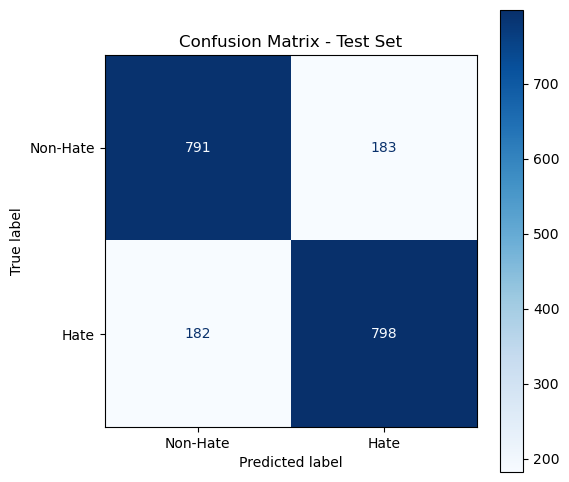

In [92]:
# Prediksi probabilitas (output dari xgb.train)
val_preds_proba = model.predict(dval)
test_preds_proba = model.predict(xgb.DMatrix(X_test))

# Ubah probabilitas menjadi kelas (threshold 0.5)
val_preds = (val_preds_proba >= 0.5).astype(int)
test_preds = (test_preds_proba >= 0.5).astype(int)

# Classification Report - Validation Set
print("Validation Report:")
print(classification_report(y_val, val_preds))

# Classification Report - Test Set
print("Test Report:")
print(classification_report(y_test, test_preds))

# Confusion Matrix - Test Set
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Hate', 'Hate'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.show()

In [93]:
# === TEST METRICS ===
y_test_proba = model.predict(dtest)
y_test_pred = (y_test_proba > 0.5).astype(int)

test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, zero_division=0)
test_rec = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)

# Tambahkan ke history
history['test_acc'] = test_acc
history['test_precision'] = test_prec
history['test_recall'] = test_rec
history['test_f1'] = test_f1

# Print hasil
print("\n=== Evaluation on Test Set ===")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall   : {test_rec:.4f}")
print(f"F1 Score : {test_f1:.4f}")


=== Evaluation on Test Set ===
Accuracy : 0.8132
Precision: 0.8135
Recall   : 0.8143
F1 Score : 0.8139


# Visualisai Graph Evaluasi

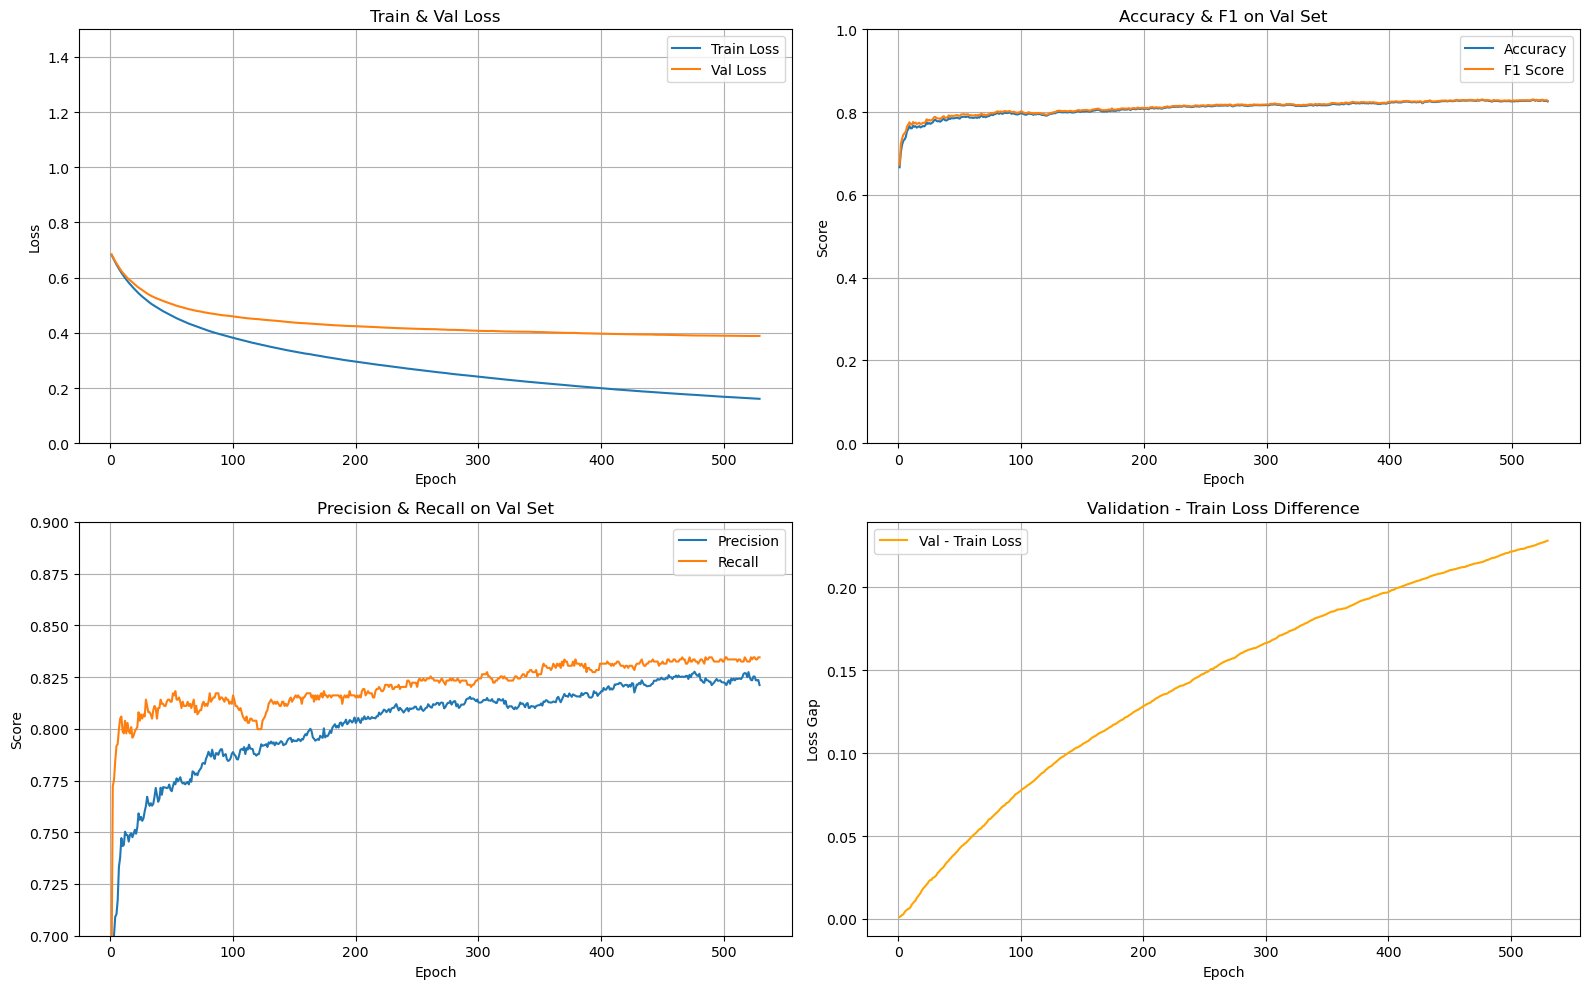

In [94]:
# Jumlah boosting rounds = jumlah epoch (1 round ≈ 1 epoch untuk XGBoost)
epochs = range(1, len(history['train_loss']) + 1)  # agar panjangnya sama


plt.figure(figsize=(16, 10))    # size 16x10

# Subplot 1: Train Loss vs Validation Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Val Loss')
plt.ylim(0, 1.5)  # Batas y-axis
plt.grid(True)
plt.legend()

# Subplot 2: Accuracy vs F1 Score
plt.subplot(2, 2, 2)
plt.plot(epochs, history['val_acc'], label='Accuracy')
plt.plot(epochs, history['val_f1'], label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Accuracy & F1 on Val Set')
plt.ylim(0, 1)  # Batas y-axis
plt.grid(True)
plt.legend()

# Subplot 3: Precision vs Recall
plt.subplot(2, 2, 3)
plt.plot(epochs, history['val_precision'], label='Precision')
plt.plot(epochs, history['val_recall'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Precision & Recall on Val Set')
plt.ylim(0.7, 0.9)  # Batas y-axis
plt.grid(True)
plt.legend()

# Subplot 4 : Delta tran - val loss
plt.subplot(2, 2, 4)
val_logloss = evals_result['val']['logloss']
train_logloss = evals_result['train']['logloss']

# Pastikan panjangnya sama
min_len = min(len(val_logloss), len(train_logloss))
delta = [v - t for v, t in zip(val_logloss[:min_len], train_logloss[:min_len])]

# Untuk sumbu x: range berdasarkan panjang data delta
x_range = range(1, min_len + 1)

plt.plot(x_range, delta, color='orange', label='Val - Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Gap')
plt.title('Validation - Train Loss Difference')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Save Report (JSON)

In [95]:
# Prediksi probabilitas & kelas pada test set
test_dmatrix = xgb.DMatrix(X_test)
test_preds_proba = model.predict(test_dmatrix)
test_preds = (test_preds_proba >= 0.5).astype(int)

# Hitung metrik
accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds, zero_division=0)
recall = recall_score(y_test, test_preds, zero_division=0)
f1 = f1_score(y_test, test_preds, zero_division=0)
roc_auc = roc_auc_score(y_test, test_preds_proba)
val_loss = history['val_loss'][-1]
train_loss = history['train_loss'][-1]
test_logloss = log_loss(y_test, test_preds_proba)

# Confusion matrix dan Specificity
cm = confusion_matrix(y_test, test_preds)
tn, fp, fn, tp = cm.ravel()

# Support per class
class_support = {int(k): int(v) for k, v in Counter(y_test).items()}

correct_predictions = int((test_preds == y_test).sum())
total_samples = len(y_test)

# Siapkan dict final report
final_report = {
    "accuracy": round(accuracy, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1_score": round(f1, 4),
    "roc_auc": round(roc_auc, 4),
    "validation_loss": round(val_loss, 4),
    "training_loss": round(train_loss, 4),
    "test_log_loss": round(test_logloss, 4),
    "support_per_class": class_support,
    "correct_predictions": correct_predictions,
    "total_samples": total_samples,
    "confusion_matrix": {
        "labels": ['Non-Hate', 'Hate'],
        "matrix": cm.tolist()
    }
}

# Simpan ke JSON
with open('xgboost_classification_report.json', 'w') as f:
    json.dump(final_report, f, indent=2)

print("Final report saved to 'xgboost_classification_report.json'")

Final report saved to 'xgboost_classification_report.json'


# Save Model & Predict Text 

In [96]:
# Simpan model setelah training
model.save_model('xgb_model.json')
print("Model berhasil disimpan!")

Model berhasil disimpan!


In [97]:
# Load model dari file
loaded_model = xgb.Booster()
loaded_model.load_model('xgb_model.json')
print("Model berhasil dimuat!")

Model berhasil dimuat!


In [98]:
def predict_text_bert(text, model):
    embedding = get_bert_embedding(text)                
    dmatrix = xgb.DMatrix(embedding.reshape(1, -1))     
    proba = model.predict(dmatrix)[0]                    
    label = 'Hate' if proba >= 0.5 else 'Non-Hate'
    confidence = proba if label == 'Hate' else 1 - proba
    return {
        'prediction': label,
        'confidence': f"{round(confidence * 100, 2)}%"
    }

# Contoh penggunaan
text = "Sumpah ya! Orang kayak kamu cuma bikin masalah. Mending diem daripada ngomong ngaco terus"

result = predict_text_bert(text, loaded_model)
print(f"Text: {text}")
print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']})")


Text: Sumpah ya! Orang kayak kamu cuma bikin masalah. Mending diem daripada ngomong ngaco terus
Prediction: Hate (Confidence: 77.39%)


In [99]:
# Contoh teks baru
text = "dasar sdm rendah, malah kerumunik lakalantas kasih jalan dong medis gimana mau maju indonesia"

# Prediksi pakai model yang sudah dimuat
result = predict_text_bert(text, loaded_model)
print(f"Text: {text}")
print(f"Prediction: {result['prediction']}")

Text: dasar sdm rendah, malah kerumunik lakalantas kasih jalan dong medis gimana mau maju indonesia
Prediction: Hate


In [54]:
# # Save pipeline model 
# pipeline = {
#     "tokenizer": tokenizer,
#     "bert_model": bert_model,
#     "xgb_model": xgb_model
# }

# joblib.dump(pipeline, "bert_xgb_pipeline.joblib")
# print("Pipeline berhasil disimpan.")